# Assignment 1: Tabular Methods

Name: Xiangyuan Ren

ID: A53249047

This exercise requires you to solve a simple grid-world problem called 'FrozenLake-v0' in OpenAI Gym.  We will solve the problem in two different ways. First we will solve the problem using dynamic programming, thus requiring a model of the system. Second we will do it using model-free temporal difference (Q-Learning). Finally, as a bonus you may also show it learning using a naive approach called hill-climbing. 

### Required for all 
#### Set up environment

In [2]:
%matplotlib inline
import gym
import numpy as np
from matplotlib import pyplot as plt
env = gym.make('FrozenLake-v0')

#### Pre. Test Policy Function
Write a function to test a policy. Return the average rate of successful episodes over 100 trials. 

In [3]:
def testPolicy(policy):
    success=0
    for i_episode in range(100):
        observation = env.reset()
        tmpdone = False
        while not(tmpdone):
            #env.render()
            #print(observation)
            action = policy[env.env.s]
            observation, reward, done, info = env.step(action)
            #print(reward),
            if done:
                if reward>0:
                    success+=1
                #print("done")
                break
            tmpdone = done
    percentSuccess=success*1.0/100
    return percentSuccess

## Model-based Learning

### 1. Policy Iteration
Perform policy iteration on the Frozenlake example. 


#### 1.1 Find the system model
First, model $T(s,a,s')$ and $R(s,a,s')$ over 100000 randomly initializations.

In [4]:
def learnModel():
    T=np.zeros((16,4,16))
    R=np.zeros((16,4,16))
    N=np.zeros((16,4))
    state = env.reset()
    s0=np.random.choice(16,size=((100000)))
    a =np.random.choice( 4,size=((100000)))
    for t in range(100000):
        env.env.s = int(s0[t])
        observation, reward, done, info = env.step(a[t])
        T[s0[t],a[t],observation]+=1
        R[s0[t],a[t],observation]+=reward
        N[s0[t],a[t]]+=1
    for x in range(16):
        for y in range(4):
            T[x,y,:]=T[x,y,:]/N[x,y]
            R[x,y,:]=R[x,y,:]/N[x,y]
    return R,T

#first learn the model    
[R,T] = learnModel()

#### 1.2 What does the transition model tell you about the stochastic behavior of actions? What does it tell you about the stochasticity  of the rewards? What would you expect an optimal agent's policy to do?

ans: For each given action, the agent may go into three different direction with 1/3 probability. For rewards, only in the location 14, will agent able to get reward.

#### 1.3 Write a function for Policy Evaluation

In [7]:
#runPolicyEvaluation:
def runPolicyEvaluation(policy,V,R,T,discount_factor):
    Converge = False
    iters = 0 
    while not(Converge):
        diff = 0
        for s0 in range(15,-1,-1):
            v = 0
            a = int(policy[s0])
            for s1 in range(16):
                if T[s0,a,s1]==0:
                    continue
                v+= T[s0,a,s1]*(R[s0,a,s1]+discount_factor*V[s1])
                #print(s0,a,s1,v)
            diff = max(diff,abs(v-V[s0]))
            #print(diff)
            V[s0] = v
        iters += 1
        if diff < 1e-8:
            Converge = True
        
    Vnew = V
    #print(iters)
    return Vnew

#### 1.4 Run Policy iteration.
and show a bar graph of successful runs vs iteration on the policy. Use a discount factor of 0.98, and terminate policy  after 40 iterations of policy updates.  Plot the percentSuccesses at every iteration (i.e. the return of the testPolicy function).

Policy iteration policy: [ 0.  3.  3.  3.  0.  0.  0.  0.  3.  1.  0.  0.  0.  2.  1.  0.]


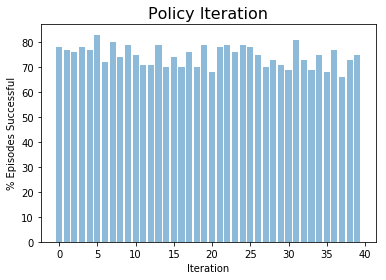

In [8]:
V=np.zeros((16));
policy=np.ones(16);
percentSuccesses=[]
for iters in range(40):
    V = runPolicyEvaluation(policy=policy,V=V,R=R,T=T,discount_factor=0.98)   
    pstate=True
    for s0 in range(16):
        tmp = policy[s0]
        l = []
        for a in range(4):
            tt = 0
            for s1 in range(16):
                tt+=T[s0,a,s1]*(R[s0,a,s1]+0.98*V[s1])
            l.append(tt)
        policy[s0]=np.argmax(l)
        if tmp!=policy[s0]:
            pstate=False
    percentSuccesses.append(testPolicy(policy))
    #if pstate==True:
    #    break
# plot improvement over time
plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iteration') 
plt.title('Policy Iteration',fontsize=16)  
print('Policy iteration policy:', policy)

## Model-Free Learning

### 2 Q Value-Iteration (Q-Learning)

#### 2.1 Set up a Q learning function
Set your exploration rate to 1-episode_num/total_num_of_episodes for linear convergence from completely random action selection to a greedy policy. Return a set of policies (at 5%, 10%,...100% of the total number of episodes) so that in the later section you can perform policy evaluation on intermediate Q-tables and show progress.

In [29]:
def find_action(a1,e):
    p=np.random.rand()
    if p<1-3*e/4:
        return a1
    else:
        while(1):
            tmp=np.random.choice(4)
            if tmp!=a1:
                return tmp
def runQLearning(learning_rate,discount_factor,num_of_episodes,Q0,explore_type='linear'):
    Q_saved=[]
    Q=Q0
    #Q_saved.append(Q)
    state=env.reset()
    for n_eps in range(num_of_episodes):#for n_eps in range(num_of_episodes):
        e=1-n_eps*1.0/num_of_episodes
        s0=np.random.choice(16)
        env.env.s=int(s0)
        #env.render()
        while(1):
            a1=np.argmax(Q[s0,:])
            a = find_action(a1,e)
            s1, reward, done, info =env.step(a)
            Q[s0,a]+=(1-learning_rate)*(reward+discount_factor*np.max(Q[s1,:])-Q[s0,a])
            #env.render()
            s0=s1
            if done==True:
                break
        if (n_eps+1)%5000==0:
            #print(n_eps),
            Q_saved.append(Q.copy()) #save last Q
    return Q_saved



#### 2.1 Perform Q-learning. 
Show policies during intermediate phases of Q-learning, at 0, 10%, 20%,...,100% of the total episodes during training. Set a learning rate of 0.98 and a discount factor of 0.95. Start with a zero-filled Q-table. Run 10000 episodes. Plot the bar graph of the success rate over time to visualize the improvements to success rate the new policies are providing. 

Q-learning (linear) policy: [ 0.  3.  0.  3.  0.  0.  2.  0.  3.  1.  0.  0.  0.  2.  1.  0.]


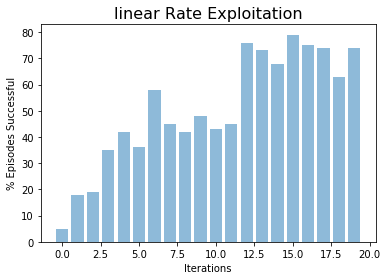

In [30]:

Q_saved=runQLearning(learning_rate=0.98,discount_factor=0.95,num_of_episodes=100000,Q0=np.zeros((16,4)))
percentSuccesses=[]
for i in range(len(Q_saved)):
    Q=Q_saved[i]
    policy=np.zeros(16)
    for x in range(16):
        policy[x]=np.argmax(Q[x,:])
    acc=testPolicy(policy)
    percentSuccesses.append(acc)

plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iterations')
plt.title('linear Rate Exploitation', fontsize=16)
print('Q-learning (linear) policy:', policy)

#### 1.4 Log Rate Exploration

Run Q-learning for a log exploration rate, $\frac{1000}{1000+\text{episode_num}}$, for 10,000 episodes. Perform policy evaluation and plot the success rate over time. You may find setting Q0 to a random number initialization helps (set it to something very small, i.e. 0.000001\*rand(), since setting it to zero sets a fixed seed).

Q-learning (log) policy: [ 0.  3.  0.  3.  0.  3.  2.  1.  3.  1.  0.  0.  1.  2.  1.  0.]


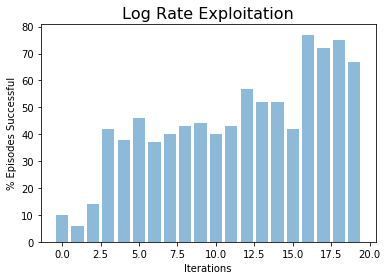

In [34]:
learning_rate=0.98; discount_factor=0.95;num_of_episodes=100000;
Q_saved=[]
Q=np.random.rand(16,4)*0.000001
Q[15,:]=np.zeros((1,4))
state=env.reset()
for n_eps in range(num_of_episodes):
    e=10000.0/(10000+n_eps)
    s0=np.random.choice(16)
    env.env.s=int(s0)
    #env.render()
    while(1):
        a1=np.argmax(Q[s0,:])
        a = find_action(a1,e)
        s1, reward, done, info =env.step(a)
        Q[s0,a]+=(1-learning_rate)*(reward+discount_factor*np.max(Q[s1,:])-Q[s0,a])
        #env.render()
        s0=s1
        if done==True:
            break
    if (n_eps+1)%5000==0:
        #print(n_eps),
        Q_saved.append(Q.copy()) #save last Q
percentSuccesses=[]
for i in range(len(Q_saved)):
    Q=Q_saved[i]
    policy=np.zeros(16)
    for x in range(16):
        policy[x]=np.argmax(Q[x,:])
    acc=testPolicy(policy)
    percentSuccesses.append(acc)


plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iterations')
plt.title('Log Rate Exploitation', fontsize=16)
print('Q-learning (log) policy:', policy)

# BONUS: Hill Climbing (25%, granted only if Parts 1 and 2 are complete)

Demonstrate hill climbing, where your Q values are chosen randomly, and you save improvements, with new Q values to try as $$Q_{test}\leftarrow Q_{best}+rand(S,A)$$
Plot the a bar graph with x-axis labelling the iteration number when an improvement occurred, and y axis as the % of successful episodes. Run on N = 1000 iterations of hill climbing, with 100 episodes per iteration. 

[ 0.  1.  1.  1.  0.  3.  0.  1.  3.  1.  1.  3.  2.  1.  3.  0.] : Hill-climbing policy


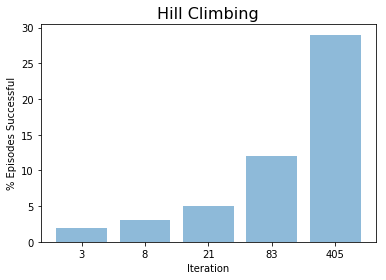

In [38]:
Q=np.random.rand(16,4)* 0.000001
Q[15,:]=np.zeros((1,4))
policy=np.zeros(16)
percentSuccesses=[]
improvementsIndex=[]
for x in range(16):
    policy[x]=np.argmax(Q[x,:])
acc=testPolicy(policy)
#print(0,acc)
for iters in range(1000):
    Qtmp=Q+np.random.rand(16,4)* 0.000001
    policytmp=np.zeros(16)
    for x in range(16):
        policytmp[x]=np.argmax(Qtmp[x,:])
    acctmp=testPolicy(policytmp)
    if acctmp>acc:
        policy=policytmp
        acc=acctmp
        percentSuccesses.append(acc)
        improvementsIndex.append(iters)



plt.figure()
plt.bar(np.arange(len(improvementsIndex)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.xticks(np.arange(len(improvementsIndex)),improvementsIndex) 
plt.ylabel('% Episodes Successful')
plt.xlabel('Iteration')
plt.title('Hill Climbing',fontsize=16)
print(policy,': Hill-climbing policy')
